In [2]:
import matplotlib.image as img
from PIL import Image
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

In [2]:
import torch
model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)
model.eval()

Using cache found in C:\Users\inesp/.cache\torch\hub\pytorch_vision_v0.6.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [19]:
data_transforms = {
    'Training Tiny': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Val Tiny': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'C:/Users/inesp/Documents/3A Inès/Deep Learning/Projet/Paris'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['Training Tiny', 'Val Tiny']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['Training Tiny', 'Val Tiny']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['Training Tiny', 'Val Tiny']}
class_names = image_datasets['Training Tiny'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(image_datasets)
# print(class_names)
print(iter(dataloaders))

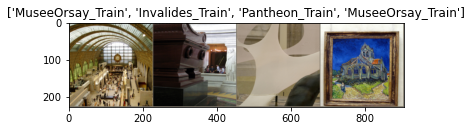

In [20]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['Training Tiny']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [21]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    training_loss = []
    validation_loss = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Training Tiny', 'Val Tiny']:
            if phase == 'Training Tiny':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]: #depends on the number of batches chosen
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Training Tiny'): #sets gradient calculations to on or off
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # training_loss.append(loss)

                    # backward + optimize only if in training phase
                    if phase == 'Training Tiny':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'Training Tiny':
                scheduler.step()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'Training Tiny':
                training_loss.append(epoch_loss)
            else:
                validation_loss.append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'Val Tiny' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())


    print('validation loss: ' + str(validation_loss))
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    plt.plot(training_loss, 'b', label='Training Loss')
    plt.plot(validation_loss, 'r', label='Validation Loss')
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [22]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [23]:
feature_extract = True

model_ft = models.alexnet(pretrained=True)
num_classes = 10
num_ftrs = model_ft.classifier[6].in_features
set_parameter_requires_grad(model_ft, feature_extract)
model_ft.classifier[6] = nn.Linear(num_ftrs,11)
input_size = 224


model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


Epoch 0/24
----------
Training Tiny Loss: 2.4121 Acc: 0.4241
Val Tiny Loss: 2.0339 Acc: 0.6265
Epoch 1/24
----------
Training Tiny Loss: 1.3633 Acc: 0.7089
Val Tiny Loss: 2.3429 Acc: 0.5904
Epoch 2/24
----------
Training Tiny Loss: 1.2336 Acc: 0.7057
Val Tiny Loss: 2.0484 Acc: 0.6265
Epoch 3/24
----------
Training Tiny Loss: 0.7989 Acc: 0.8038
Val Tiny Loss: 2.1962 Acc: 0.6145
Epoch 4/24
----------
Training Tiny Loss: 0.9260 Acc: 0.7658
Val Tiny Loss: 2.5667 Acc: 0.6024
Epoch 5/24
----------
Training Tiny Loss: 0.8255 Acc: 0.8323
Val Tiny Loss: 2.5762 Acc: 0.5783
Epoch 6/24
----------
Training Tiny Loss: 0.6696 Acc: 0.8386
Val Tiny Loss: 2.5940 Acc: 0.6506
Epoch 7/24
----------
Training Tiny Loss: 0.4886 Acc: 0.8671
Val Tiny Loss: 2.4955 Acc: 0.6627
Epoch 8/24
----------
Training Tiny Loss: 0.2982 Acc: 0.9114
Val Tiny Loss: 2.5129 Acc: 0.6506
Epoch 9/24
----------
Training Tiny Loss: 0.3252 Acc: 0.9177
Val Tiny Loss: 2.4868 Acc: 0.6627
Epoch 10/24
----------
Training Tiny Loss: 0.3189 

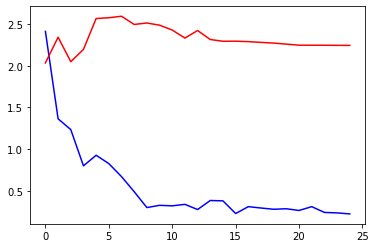

In [24]:
model_ft = train_model(model_ft, dataloaders, criterion, optimizer_ft, exp_lr_scheduler)

In [28]:
data_transforms = {'Test Tiny': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'C:/Users/inesp/Documents/3A Inès/Deep Learning/Projet/Paris'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['Test Tiny']}
dataloaders_test = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=11,
                                             shuffle=True, num_workers=4)
              for x in ['Test Tiny']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# print(iter(dataloaders_test))
# print(dataloaders_test['Test Tiny'])
#print(inputs)
for inputs, labels in dataloaders_test['Test Tiny']:
    inputs = inputs.to(device)
    labels = labels.to(device)
    # print(inputs.size())
    #print(labels)
    outputs = model_ft(inputs)
    _, preds = torch.max(outputs, 1)
    #print(preds)
    print(preds == labels)

tensor([False,  True,  True, False, False, False,  True, False,  True,  True,
         True])
tensor([False, False, False, False,  True,  True,  True, False,  True,  True,
         True])
tensor([False, False, False,  True, False,  True,  True, False, False,  True,
        False])


In [32]:
torch.save(model_ft.state_dict(),"state_dict_model.pt")